In [1]:
from keras.applications import VGG16
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks

## Pre-trained Networks: feature extraction

### 1st Way

Running the convolutional base over our dataset, recording its output to a Numpy array on disk

In [2]:
img_width, img_height = 48,48

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(img_width, img_height, 3))

58889256/58889256 [==============================] - 2s 0us/step


In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [4]:
# Define data directories
train_dir = "../data/train1"
validation_dir = "../data/validation"
test_dir = "../data/test"

batch_size = 64

datagen = ImageDataGenerator(rescale=1./255)

In [5]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 1, 1, 512))
    labels = np.zeros(shape=(sample_count,7))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 14357)
validation_features, validation_labels = extract_features(validation_dir, 14352)
test_features, test_labels = extract_features(test_dir, 7178)

Found 14357 images belonging to 7 classes.
1/1 [==============================] - 0s 252ms/step
Found 14352 images belonging to 7 classes.
1/1 [==============================] - 0s 367ms/step
Found 7178 images belonging to 7 classes.
1/1 [==============================] - 0s 292ms/step


The extracted features are currently of shape (samples, 1, 1, 512). We will feed them to a densely-connected classifier, so first we must flatten them to (samples, 512):

In [6]:
train_features = np.reshape(train_features, (14357, 1 * 1 * 512))
validation_features = np.reshape(validation_features, (14352, 1 * 1 * 512))
test_features = np.reshape(test_features, (7178, 1 * 1 * 512))

In [7]:
# Create our densely-connected classifier

model = models.Sequential()
model.add(layers.Dense(256, activation='relu',input_dim=1 * 1 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))

model.add(layers.Dense(7, activation='softmax'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                8224      
                                                                 
 dense_2 (Dense)             (None, 7)                 231       
                                                                 
Total params: 139,783
Trainable params: 139,783
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
num_epochs = 200
earlystopping = callbacks.EarlyStopping(monitor="val_accuracy",
                                        patience=10,
                                        restore_best_weights=True)

history = model.fit(train_features, train_labels,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    validation_data=(validation_features, validation_labels),
                    callbacks=[earlystopping])

Epoch 1/200
225/225 [==============================] - 1s 4ms/step - loss: 1.7314 - accuracy: 0.2991 - val_loss: 1.6377 - val_accuracy: 0.3636
Epoch 2/200
225/225 [==============================] - 1s 3ms/step - loss: 1.6366 - accuracy: 0.3572 - val_loss: 1.5974 - val_accuracy: 0.3765
Epoch 3/200
225/225 [==============================] - 1s 3ms/step - loss: 1.5977 - accuracy: 0.3752 - val_loss: 1.6171 - val_accuracy: 0.3593
Epoch 4/200
225/225 [==============================] - 1s 3ms/step - loss: 1.5696 - accuracy: 0.3885 - val_loss: 1.5763 - val_accuracy: 0.3818
Epoch 5/200
225/225 [==============================] - 1s 3ms/step - loss: 1.5525 - accuracy: 0.3955 - val_loss: 1.5615 - val_accuracy: 0.3912
Epoch 6/200
225/225 [==============================] - 1s 3ms/step - loss: 1.5345 - accuracy: 0.4039 - val_loss: 1.5495 - val_accuracy: 0.3981
Epoch 7/200
225/225 [==============================] - 1s 3ms/step - loss: 1.5156 - accuracy: 0.4157 - val_loss: 1.5466 - val_accuracy: 0.4004

In [11]:
df_history = pd.DataFrame(history.history)
df_history.head()

,loss,accuracy,val_loss,val_accuracy
0,1.731356,0.299088,1.637686,0.363643
1,1.636552,0.357178,1.597428,0.376533
2,1.597663,0.375218,1.617092,0.359323
3,1.569563,0.388452,1.576251,0.381759
4,1.552452,0.395487,1.561484,0.391235


<Axes: title={'center': 'Losses'}, xlabel='Epochs', ylabel='Loss'>

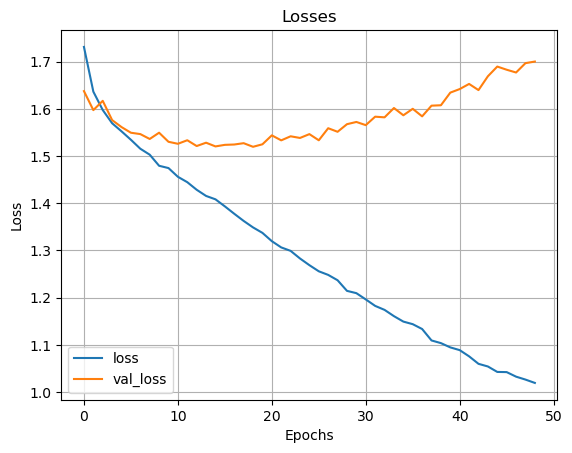

In [12]:
df_history['loss'].plot(legend=True)
df_history['val_loss'].plot(title='Losses', grid=True,
                              xlabel='Epochs',
                              ylabel='Loss',
                              legend=True)

<Axes: title={'center': 'Accuracies'}, xlabel='Epochs', ylabel='Accuracy'>

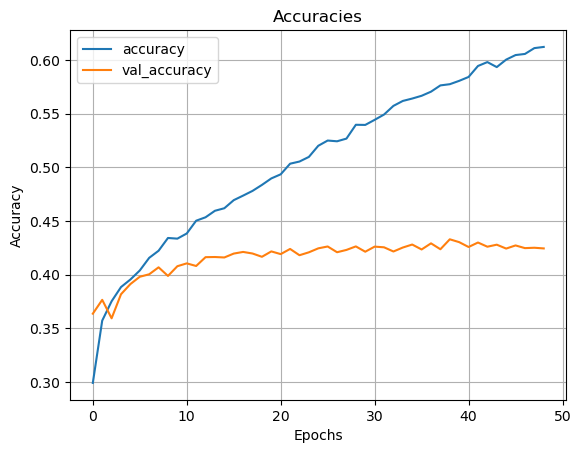

In [13]:
df_history['accuracy'].plot(legend=True)
df_history['val_accuracy'].plot(title='Accuracies', grid=True,
                              xlabel='Epochs',
                              ylabel='Accuracy',
                              legend=True)

In [14]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_features, test_labels, verbose=2)
print("\nTest accuracy:", test_acc)

Found 7178 images belonging to 7 classes.
225/225 - 0s - loss: 1.5890 - accuracy: 0.4393 - 366ms/epoch - 2ms/step

Test accuracy: 0.4392588436603546


In [15]:
model.save('model_VGG16_1stWay.h5')

### 2nd way

Extending the model we have (`conv_base`) by adding `Dense` layers on top, and running the whole thing end-to-end on the input data.

In [16]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(32, activation='relu'))

model.add(layers.Dense(7, activation='softmax'))

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 32)                8224      
                                                                 
 dense_5 (Dense)             (None, 7)                 231       
                                                                 
Total params: 14,854,471
Trainable params: 14,854,471
Non-trainable params: 0
_________________________________________________________________


In [18]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 32


In [19]:
conv_base.trainable = False

In [20]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 6


In [21]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical')


Found 14357 images belonging to 7 classes.
Found 14352 images belonging to 7 classes.


In [22]:
num_epochs = 200
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

earlystopping = callbacks.EarlyStopping(monitor="val_accuracy",
                                        patience=10,
                                        restore_best_weights=True)

history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples // batch_size,
      epochs=num_epochs,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples // batch_size,
      callbacks=[earlystopping])

Epoch 1/200


C:\Users\Alvaro\AppData\Local\Temp\ipykernel_45636\1061495183.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


224/224 [==============================] - 12s 51ms/step - loss: 1.7487 - accuracy: 0.2863 - val_loss: 1.6806 - val_accuracy: 0.3464
Epoch 2/200
224/224 [==============================] - 11s 50ms/step - loss: 1.6924 - accuracy: 0.3154 - val_loss: 1.6484 - val_accuracy: 0.3480
Epoch 3/200
224/224 [==============================] - 11s 51ms/step - loss: 1.6688 - accuracy: 0.3341 - val_loss: 1.6609 - val_accuracy: 0.3416
Epoch 4/200
224/224 [==============================] - 11s 51ms/step - loss: 1.6628 - accuracy: 0.3353 - val_loss: 1.6274 - val_accuracy: 0.3554
Epoch 5/200
224/224 [==============================] - 11s 49ms/step - loss: 1.6557 - accuracy: 0.3421 - val_loss: 1.6437 - val_accuracy: 0.3447
Epoch 6/200
224/224 [==============================] - 11s 50ms/step - loss: 1.6478 - accuracy: 0.3422 - val_loss: 1.6143 - val_accuracy: 0.3616
Epoch 7/200
224/224 [==============================] - 12s 51ms/step - loss: 1.6408 - accuracy: 0.3502 - val_loss: 1.6148 - val_accuracy: 0.36

In [23]:
model.save('model_VGG16_2ndWay.h5')

In [24]:
df_history = pd.DataFrame(history.history)
df_history.head()

,loss,accuracy,val_loss,val_accuracy
0,1.748742,0.286294,1.680583,0.346401
1,1.692402,0.315399,1.648413,0.348005
2,1.668755,0.334150,1.660886,0.341588
3,1.662811,0.335339,1.627360,0.355399
4,1.655741,0.342056,1.643733,0.344657


<Axes: title={'center': 'Losses'}, xlabel='Epochs', ylabel='Loss'>

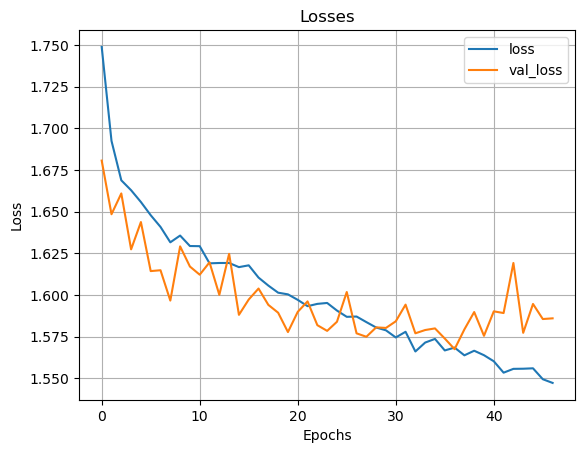

In [25]:
df_history['loss'].plot(legend=True)
df_history['val_loss'].plot(title='Losses', grid=True,
                              xlabel='Epochs',
                              ylabel='Loss',
                              legend=True)

<Axes: title={'center': 'Accuracies'}, xlabel='Epochs', ylabel='Accuracy'>

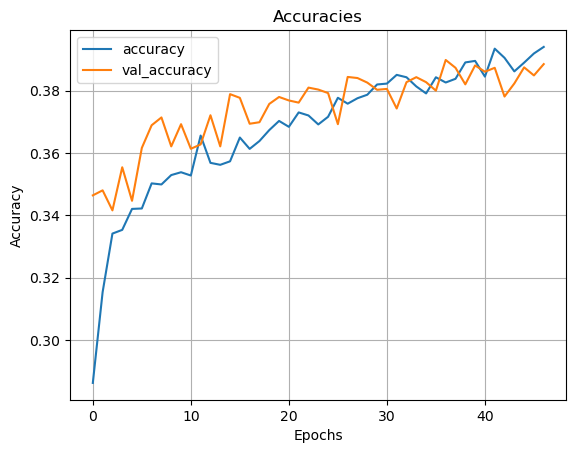

In [26]:
df_history['accuracy'].plot(legend=True)
df_history['val_accuracy'].plot(title='Accuracies', grid=True,
                              xlabel='Epochs',
                              ylabel='Accuracy',
                              legend=True)

In [27]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print("\nTest accuracy:", test_acc)

Found 7178 images belonging to 7 classes.
113/113 - 2s - loss: 1.5545 - accuracy: 0.3934 - 2s/epoch - 15ms/step

Test accuracy: 0.3934243619441986
